# Calculate distances between specific residues in pdb files

In [92]:
import matplotlib.pyplot as plt
from biopandas.pdb import PandasPdb
from os.path import exists
import numpy as np

PATH_XLS_INTRA_NONRED = 'XLs_intra_nonred.csv'
PATH_WATERSHED_LABELS = 'watershed_labels.json'

UNRELAXED_PDB_SUFFIX = '-unrelaxed_model_1.pdb'
RELAXED_PDB_SUFFIX = '-relaxed_model_1.pdb'
UNRELAXED_PTM_PDB_SUFFIX = '-unrelaxed_model_1_ptm.pdb'
RELAXED_PTM_PDB_SUFFIX = '-relaxed_model_1_ptm.pdb'
RESULTS_PKL_SUFFIX = '-result_model_1_ptm.pkl'
RELAXED_PAE_PKL_SUFFIX = '-pae_relaxed_model_1_ptm.pkl'
UNRELAXED_PAE_PKL_SUFFIX = '-pae_unrelaxed_model_1_ptm.pkl'

XL_THRESHOLD = 30

pdbs = {}
paes_relaxed = {}
paes_unrelaxed = {}


def sanitize_protein(protein_id):
    """Replace / in protein ID with _ for compatibility with file system"""
    return protein_id.replace("/", "_").replace("\xa0", "")


def calculate_dist(pdb, xl):
    """Calculate the distance between residues in the PDB based on the crosslink"""
    # Find the C atom for each residue
    res_1 = pdb.loc[pdb['residue_number'] == xl.Res1]
    res_2 = pdb.loc[pdb['residue_number'] == xl.Res2]

    res_1_coords = res_1[['x_coord', 'y_coord', 'z_coord']].to_numpy()
    res_2_coords = res_2[['x_coord', 'y_coord', 'z_coord']].to_numpy()

    return np.linalg.norm(res_1_coords - res_2_coords)


def read_pdb_ca(pdb_filepath):
    """Read atom data for the alpha carbon from a PDB at the given filepath"""
    ppdb = PandasPdb().read_pdb(pdb_filepath)  # reads pdb into pandas df
    pdbatom = ppdb.df['ATOM']  # extracts only the atom data type from pdb
    return pdbatom[(pdbatom['atom_name'] == 'CA')]  # selects the only the CA atoms


def read_protein_pdb(protein, pdb_suffix):
    """Cached read of a PDB file for the given protein with the provided file suffix"""
    if pdb_suffix not in pdbs:
        pdbs[pdb_suffix] = {}
    elif protein in pdbs[pdb_suffix]:
        return pdbs[pdb_suffix][protein]
    pdbs_with_suffix = pdbs[pdb_suffix]

    pdb_filepath = 'models/' + sanitize_protein(protein) + pdb_suffix
    if not exists(pdb_filepath):
        # print(protein + ' PDB file not found. Skipping...')
        return None
    pdb_ca = read_pdb_ca(pdb_filepath)

    pdbs_with_suffix[protein] = pdb_ca
    return pdb_ca


def read_protein_pae_relaxed(protein):
    """Cached read of PAE results for the given protein"""
    if protein in paes_relaxed:
        return paes_relaxed[protein]

    results = pd.read_pickle('pae/' + sanitize_protein(protein) + RELAXED_PAE_PKL_SUFFIX)
    pae = results['predicted_aligned_error']
    paes_relaxed[protein] = pae
    return pae


def fill_xls_from_pdb(protein_name, threshold, pdb, xls):
    """Calculate distance between residues for every cross-link for a protein in xls based on alpha carbon positions in pdb. Returns cross-links which are below the threshold distance."""
    xls['af_distance'] = xls.apply(
        lambda x: x.af_distance if x.Protein1 != protein_name else calculate_dist(pdb, x), axis=1)
    return xls[(xls['af_distance'] < threshold) & (xls['Protein1'] == protein_name)]


In [93]:
import pandas as pd
import seaborn as sns
import json

In [94]:
if exists(PATH_XLS_INTRA_NONRED):
    # Read intra-protein cross-links from file if it exists
    XLs_intra_nonred = pd.read_csv(PATH_XLS_INTRA_NONRED)
else:
    # Read in XL csv file to pandas DF
    XLs = pd.read_csv("Union_XL1_XL2_PurifiedSECa-g_IEXcilia2inject2.3-newpeptidepos.csv", encoding='unicode_escape')

    # Save all intramolecular crosslinks to a new DF
    XLs_intra = XLs.loc[XLs['Protein1'] == XLs['Protein2']]

    # Calculate the XL position in the protein primary sequence
    XLs_intra.loc[:, 'Res1'] = XLs_intra['PepPos1'] + XLs_intra['LinkPos1'] - 1
    XLs_intra.loc[:, 'Res2'] = XLs_intra['PepPos2'] + XLs_intra['LinkPos2'] - 1

    # Removes all XL redundancies
    XLs_intra.loc[:, 'newRes1'] = XLs_intra[["Res1", "Res2"]].max(axis=1)
    XLs_intra.loc[:, 'newRes2'] = XLs_intra[["Res1", "Res2"]].min(axis=1)
    XLs_intra_nonred = XLs_intra.drop_duplicates(subset=['Protein1', 'Protein2', 'newRes1', 'newRes2'], keep="last")

    # Remove all XLs with the same res1 as res2
    print(XLs_intra_nonred[XLs_intra_nonred['newRes1'] == XLs_intra_nonred['newRes2']])
    XLs_intra_nonred.drop(XLs_intra_nonred[XLs_intra_nonred['newRes1'] == XLs_intra_nonred['newRes2']].index,
                          inplace=True)

    # Save to file
    XLs_intra_nonred.to_csv(PATH_XLS_INTRA_NONRED)

In [95]:
# Extract XL counts for each protein
intra_XL_counts = XLs_intra_nonred['Protein1'].value_counts().reset_index().rename(
    columns={'index': 'Protein1', 'Protein1': 'XL_count'})
XLs_intra_nonred.loc[:, 'af_distance'] = None
XLs_intra_nonred

,Unnamed: 0,Id,Score,Protein1,PepPos1,PepSeq1,LinkPos1,Protein2,PepPos2,PepSeq2,LinkPos2,Res1,Res2,newRes1,newRes2,af_distance
0,13,14,413.29,RSPH4A/6A-2,86,KLLDPLMEGEEDNLAPVGAIGYVPNFMEEAK,1,RSPH4A/6A-2,72,EKYEAVSESFKANK,11,86,82,86,82,None
1,20,21,396.55,ILS1,935,EYNKDLKAAAGNLSAK,7,ILS1,921,AIPNHKLLGQK,6,941,926,941,926,None
2,35,36,369.15,I7LU32,298,TQIHTSYGLNQHKEAISLFR,13,I7LU32,318,KVQGGQK,1,310,318,318,310,None
3,70,71,338.56,CDC27,742,SQKEIEDQKK,3,CDC27,752,KLDEELLR,1,744,752,752,744,None
4,75,76,335.56,IDP2,345,AKLDNNKELDLFCK,7,IDP2,408,KNLVAAKSNL,7,351,414,414,351,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3392,19421,19422,146.57,IFT52,40,NKEDITYDR,2,IFT52,33,ETYKCGR,4,41,36,41,36,None
3393,19422,19423,155.26,IFT144,965,LNLDKLDNLR,5,IFT144,935,QYAKAK,4,969,938,969,938,None
3394,19424,19425,132.32,CCT5,46,SSLGPKGMDK,6,CCT5,173,VVSKNKR,6,51,178,178,51,None
3395,19425,19426,155.99,IFT81,480,NKTEYDQMLKK,10,IFT81,491,LEKEK,3,489,493,493,489,None


In [96]:
def get_af_xl_counts(protein_xl_counts, threshold, pdb_suffix):
    """Retrieve the number of cross-links for this protein where the residue distance in the PDB with the given suffix is below the threshold."""
    protein = protein_xl_counts['Protein1']
    pdb_ca = read_protein_pdb(protein, pdb_suffix)
    if pdb_ca is None:
        return None
    return fill_xls_from_pdb(protein, threshold, pdb_ca, XLs_intra_nonred).count()['Id']

In [97]:
intra_XL_counts['af_unrelaxed_XL_count'] = intra_XL_counts.apply(
    lambda x: get_af_xl_counts(x, XL_THRESHOLD, UNRELAXED_PDB_SUFFIX), axis=1)

In [98]:
intra_XL_counts[intra_XL_counts['af_unrelaxed_XL_count'].notnull()]

,Protein1,XL_count,af_unrelaxed_XL_count
4,PRKG1,38,36.0
5,EEF2,35,25.0
6,MRNC57,34,25.0
9,I7MJ59,30,15.0
10,EMAP5/6-1,30,30.0
...,...,...,...
128,I7MHD4,7,7.0
131,CCDC81-1,7,6.0
136,DRH29,7,6.0
138,I7LTB9,7,4.0


In [99]:
def read_confidence(intra_xl_counts):
    """Read the overall PLDDT for the unrelaxed model 1 prediction from the ranking file."""
    protein = intra_xl_counts['Protein1']

    ranking_filepath = 'rankings/' + sanitize_protein(protein) + '-ranking_debug.json'
    if not exists(ranking_filepath):
        if not np.isnan(intra_xl_counts['af_unrelaxed_XL_count']):
            print('Rankings for', protein, 'not found.')
        return None

    with open(ranking_filepath) as ranking_file:
        ranking_debug = json.load(ranking_file)
        if 'model_1' in ranking_debug['plddts']:
            return ranking_debug['plddts']['model_1']
        else:
            print('Did not have model_1 plddt (was predicted using Alphafold 2.2):', protein)
            return ranking_debug['plddts']['model_1_pred_0']


intra_XL_counts['confidence'] = intra_XL_counts.apply(lambda x: read_confidence(x), axis=1)

Did not have model_1 plddt (was predicted using Alphafold 2.2): SPAG17
Did not have model_1 plddt (was predicted using Alphafold 2.2): UBXN2A/B


In [100]:
intra_XL_counts['XL_agreement'] = intra_XL_counts['af_unrelaxed_XL_count'] / intra_XL_counts['XL_count']
intra_XL_counts[intra_XL_counts['af_unrelaxed_XL_count'].notnull()]

,Protein1,XL_count,af_unrelaxed_XL_count,confidence,XL_agreement
4,PRKG1,38,36.0,78.041609,0.947368
5,EEF2,35,25.0,89.479929,0.714286
6,MRNC57,34,25.0,68.385990,0.735294
9,I7MJ59,30,15.0,67.924191,0.500000
10,EMAP5/6-1,30,30.0,76.297715,1.000000
...,...,...,...,...,...
128,I7MHD4,7,7.0,95.693012,1.000000
131,CCDC81-1,7,6.0,68.906479,0.857143
136,DRH29,7,6.0,82.161582,0.857143
138,I7LTB9,7,4.0,38.950922,0.571429


In [101]:
intra_XL_counts[intra_XL_counts['XL_agreement'] == 1]

,Protein1,XL_count,af_unrelaxed_XL_count,confidence,XL_agreement
10,EMAP5/6-1,30,30.0,76.297715,1.0
13,EARS,24,24.0,91.715565,1.0
14,EMAP5/6-2,22,22.0,75.772186,1.0
21,PRKAR1A,18,18.0,76.863226,1.0
23,SARS,17,17.0,86.568760,1.0
26,HSPA4,17,17.0,85.202522,1.0
31,I7M3K6,15,15.0,77.849084,1.0
36,PGM1,14,14.0,94.200454,1.0
42,AK1-1,13,13.0,81.286353,1.0
45,I7M328,13,13.0,89.782138,1.0


In [102]:
intra_XL_counts[intra_XL_counts['XL_agreement'] < 1]

,Protein1,XL_count,af_unrelaxed_XL_count,confidence,XL_agreement
4,PRKG1,38,36.0,78.041609,0.947368
5,EEF2,35,25.0,89.479929,0.714286
6,MRNC57,34,25.0,68.385990,0.735294
9,I7MJ59,30,15.0,67.924191,0.500000
11,FTT18,25,21.0,95.138586,0.840000
12,BBC118,25,15.0,85.481704,0.600000
16,Q23A15,20,12.0,75.527561,0.600000
22,KARS,18,12.0,84.987008,0.666667
24,CAPN-1,17,14.0,75.297798,0.823529
25,I7MKN3,17,16.0,72.773157,0.941176


In [103]:
intra_XL_counts[intra_XL_counts['XL_count'] - intra_XL_counts['af_unrelaxed_XL_count'] <= 3]

,Protein1,XL_count,af_unrelaxed_XL_count,confidence,XL_agreement
4,PRKG1,38,36.0,78.041609,0.947368
10,EMAP5/6-1,30,30.0,76.297715,1.000000
13,EARS,24,24.0,91.715565,1.000000
14,EMAP5/6-2,22,22.0,75.772186,1.000000
21,PRKAR1A,18,18.0,76.863226,1.000000
...,...,...,...,...,...
128,I7MHD4,7,7.0,95.693012,1.000000
131,CCDC81-1,7,6.0,68.906479,0.857143
136,DRH29,7,6.0,82.161582,0.857143
138,I7LTB9,7,4.0,38.950922,0.571429


<AxesSubplot:xlabel='XL_agreement', ylabel='confidence'>

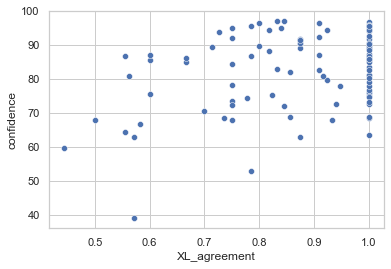

In [104]:
sns.scatterplot(x=intra_XL_counts['XL_agreement'], y=intra_XL_counts['confidence'])

In [105]:
intra_XL_counts[intra_XL_counts['confidence'] < 70]

,Protein1,XL_count,af_unrelaxed_XL_count,confidence,XL_agreement
6,MRNC57,34,25.0,68.385990,0.735294
9,I7MJ59,30,15.0,67.924191,0.500000
32,SPAG17,15,14.0,67.802790,0.933333
40,UBXN2A/B,14,11.0,52.971408,0.785714
51,TRAF3IP1,12,7.0,66.892961,0.583333
70,Q22T19,10,10.0,63.391836,1.000000
81,Q22MP6,9,4.0,59.571289,0.444444
86,SPEF2,9,5.0,64.367416,0.555556
107,EPC1,8,6.0,68.047634,0.750000
110,CDC27,8,7.0,62.773771,0.875000


In [106]:
XLs_intra_nonred[XLs_intra_nonred['af_distance'].notnull()]

,Unnamed: 0,Id,Score,Protein1,PepPos1,PepSeq1,LinkPos1,Protein2,PepPos2,PepSeq2,LinkPos2,Res1,Res2,newRes1,newRes2,af_distance
1,20,21,396.55,ILS1,935,EYNKDLKAAAGNLSAK,7,ILS1,921,AIPNHKLLGQK,6,941,926,941,926,11.486842
3,70,71,338.56,CDC27,742,SQKEIEDQKK,3,CDC27,752,KLDEELLR,1,744,752,752,744,11.888002
4,75,76,335.56,IDP2,345,AKLDNNKELDLFCK,7,IDP2,408,KNLVAAKSNL,7,351,414,414,351,12.968525
5,110,111,324.58,I7LUZ1,315,VICILDKPIPGTKDIPSVQIIIPQR,13,I7LUZ1,128,VPANDKEALQSDLMGLLEK,6,327,133,327,133,17.507300
8,247,248,299.14,Q234E6,487,AQVVEQSLEKHIQNEK,10,Q234E6,603,SKAGTVTR,2,496,604,604,496,18.352268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342,19345,19346,138.44,IFT172,556,QLYLYNIKTQTK,8,IFT172,496,LNYHSVKQTK,7,563,502,563,502,15.064587
3348,19355,19356,119.83,IFT172,206,SNKSQVMYSTDSYVVSLAACK,3,IFT172,199,VKSGILR,2,208,200,208,200,10.165514
3363,19378,19379,84.75,DLD,43,AGQLGLKTACVEK,7,DLD,127,NKVDYFVGTGR,2,49,128,128,49,7.841158
3376,19400,19401,132.50,DLD,127,NKVDYFVGTGR,2,DLD,119,GIESLFKK,7,128,125,128,125,4.894888


## Determine overall XL agreement percentage for unrelaxed predictions

In [107]:
af_xls = XLs_intra_nonred[XLs_intra_nonred['af_distance'].notnull()]
print('Total intramolecular XLs in proteins with AF predictions:', len(af_xls))
print('% XL Agreement: {}'.format((af_xls['af_distance'] <= XL_THRESHOLD).mean() * 100))

Total intramolecular XLs in proteins with AF predictions: 1225
% XL Agreement: 86.04081632653062


In [108]:
XLs_intra_nonred['xl_violated'] = XLs_intra_nonred['af_distance'] > XL_THRESHOLD


def is_low_confidence(protein):
    """Determine if the PLDDT score for a protein prediction is low confidence, below 70."""
    return intra_XL_counts[intra_XL_counts['Protein1'] == protein].iloc[0]['confidence'] < 70


XLs_intra_nonred['low_protein_confidence'] = None
XLs_intra_nonred['low_protein_confidence'] = XLs_intra_nonred.apply(lambda x: is_low_confidence(x['Protein1']), axis=1)

pd.crosstab(XLs_intra_nonred['xl_violated'], XLs_intra_nonred['low_protein_confidence'], normalize='index')

low_protein_confidence,False,True
xl_violated,,
False,0.958772,0.041228
True,0.695906,0.304094


## Comparisons between different model predictions

In [109]:
intra_XL_counts['af_relaxed_XL_count'] = intra_XL_counts.apply(
    lambda x: get_af_xl_counts(x, XL_THRESHOLD, RELAXED_PDB_SUFFIX),
    axis=1)
intra_XL_counts['af_relaxed_ptm_XL_count'] = intra_XL_counts.apply(
    lambda x: get_af_xl_counts(x, XL_THRESHOLD, RELAXED_PTM_PDB_SUFFIX), axis=1)
intra_XL_counts['af_unrelaxed_ptm_XL_count'] = intra_XL_counts.apply(
    lambda x: get_af_xl_counts(x, XL_THRESHOLD, UNRELAXED_PTM_PDB_SUFFIX), axis=1)

### Compare Unrelaxed vs Relaxed XL counts

In [110]:
top_10_XL_proteins = [
    'PRKG1',
    'EEF2',
    'MRNC57',
    'EMAP5/6-1',
    'I7MJ59',
    'BBC118',
    'FTT18',
    'EARS',
    'EMAP5/6-2',
    'Q23A15'
]

intra_XL_counts['relaxed_XL_agreement'] = intra_XL_counts['af_relaxed_XL_count'] / intra_XL_counts['XL_count']
intra_XL_counts['relaxed_vs_unrelaxed_diff'] = intra_XL_counts['af_relaxed_XL_count'] - intra_XL_counts['af_unrelaxed_XL_count']
intra_XL_counts[intra_XL_counts['Protein1'].isin(top_10_XL_proteins)]

,Protein1,XL_count,af_unrelaxed_XL_count,confidence,XL_agreement,af_relaxed_XL_count,af_relaxed_ptm_XL_count,af_unrelaxed_ptm_XL_count,relaxed_XL_agreement,relaxed_vs_unrelaxed_diff
4,PRKG1,38,36.0,78.041609,0.947368,35.0,36.0,37.0,0.921053,-1.0
5,EEF2,35,25.0,89.479929,0.714286,25.0,25.0,25.0,0.714286,0.0
6,MRNC57,34,25.0,68.385990,0.735294,24.0,24.0,26.0,0.705882,-1.0
9,I7MJ59,30,15.0,67.924191,0.500000,17.0,17.0,15.0,0.566667,2.0
10,EMAP5/6-1,30,30.0,76.297715,1.000000,30.0,NaN,28.0,1.000000,0.0
11,FTT18,25,21.0,95.138586,0.840000,21.0,21.0,21.0,0.840000,0.0
12,BBC118,25,15.0,85.481704,0.600000,15.0,15.0,15.0,0.600000,0.0
13,EARS,24,24.0,91.715565,1.000000,24.0,NaN,24.0,1.000000,0.0
14,EMAP5/6-2,22,22.0,75.772186,1.000000,22.0,NaN,22.0,1.000000,0.0
16,Q23A15,20,12.0,75.527561,0.600000,14.0,13.0,14.0,0.700000,2.0


In [111]:
intra_XL_counts[intra_XL_counts['Protein1'].isin(top_10_XL_proteins)]['relaxed_vs_unrelaxed_diff'].mean()

0.2

### Compare Relaxed to Relaxed PTM XL counts for example proteins

In [112]:
intra_XL_counts['relaxed_ptm_XL_agreement'] = intra_XL_counts['af_relaxed_ptm_XL_count'] / intra_XL_counts['XL_count']
intra_XL_counts['relaxed_ptm_vs_relaxed_diff'] = intra_XL_counts['af_relaxed_ptm_XL_count'] - intra_XL_counts['af_relaxed_XL_count']
intra_XL_counts[intra_XL_counts['relaxed_ptm_XL_agreement'].notnull()]

,Protein1,XL_count,af_unrelaxed_XL_count,confidence,XL_agreement,af_relaxed_XL_count,af_relaxed_ptm_XL_count,af_unrelaxed_ptm_XL_count,relaxed_XL_agreement,relaxed_vs_unrelaxed_diff,relaxed_ptm_XL_agreement,relaxed_ptm_vs_relaxed_diff
4,PRKG1,38,36.0,78.041609,0.947368,35.0,36.0,37.0,0.921053,-1.0,0.947368,1.0
5,EEF2,35,25.0,89.479929,0.714286,25.0,25.0,25.0,0.714286,0.0,0.714286,0.0
6,MRNC57,34,25.0,68.385990,0.735294,24.0,24.0,26.0,0.705882,-1.0,0.705882,0.0
9,I7MJ59,30,15.0,67.924191,0.500000,17.0,17.0,15.0,0.566667,2.0,0.566667,0.0
11,FTT18,25,21.0,95.138586,0.840000,21.0,21.0,21.0,0.840000,0.0,0.840000,0.0
12,BBC118,25,15.0,85.481704,0.600000,15.0,15.0,15.0,0.600000,0.0,0.600000,0.0
16,Q23A15,20,12.0,75.527561,0.600000,14.0,13.0,14.0,0.700000,2.0,0.650000,-1.0
22,KARS,18,12.0,84.987008,0.666667,12.0,12.0,12.0,0.666667,0.0,0.666667,0.0
28,I7M6H8,16,9.0,81.030202,0.562500,9.0,9.0,9.0,0.562500,0.0,0.562500,0.0
51,TRAF3IP1,12,7.0,66.892961,0.583333,7.0,7.0,7.0,0.583333,0.0,0.583333,0.0


In [113]:
intra_XL_counts[intra_XL_counts['relaxed_ptm_vs_relaxed_diff'].notnull()]['relaxed_ptm_vs_relaxed_diff'].mean()

-0.14285714285714285

### Compare Unrelaxed PTM to Relaxed PTM XL counts for example proteins

In [114]:
intra_XL_counts['unrelaxed_ptm_XL_agreement'] = intra_XL_counts['af_unrelaxed_ptm_XL_count'] / intra_XL_counts['XL_count']
intra_XL_counts['unrelaxed_ptm_vs_relaxed_ptm_diff'] = intra_XL_counts['af_unrelaxed_ptm_XL_count'] - intra_XL_counts['af_relaxed_ptm_XL_count']
intra_XL_counts[intra_XL_counts['relaxed_ptm_XL_agreement'].notnull()]

,Protein1,XL_count,af_unrelaxed_XL_count,confidence,XL_agreement,af_relaxed_XL_count,af_relaxed_ptm_XL_count,af_unrelaxed_ptm_XL_count,relaxed_XL_agreement,relaxed_vs_unrelaxed_diff,relaxed_ptm_XL_agreement,relaxed_ptm_vs_relaxed_diff,unrelaxed_ptm_XL_agreement,unrelaxed_ptm_vs_relaxed_ptm_diff
4,PRKG1,38,36.0,78.041609,0.947368,35.0,36.0,37.0,0.921053,-1.0,0.947368,1.0,0.973684,1.0
5,EEF2,35,25.0,89.479929,0.714286,25.0,25.0,25.0,0.714286,0.0,0.714286,0.0,0.714286,0.0
6,MRNC57,34,25.0,68.385990,0.735294,24.0,24.0,26.0,0.705882,-1.0,0.705882,0.0,0.764706,2.0
9,I7MJ59,30,15.0,67.924191,0.500000,17.0,17.0,15.0,0.566667,2.0,0.566667,0.0,0.500000,-2.0
11,FTT18,25,21.0,95.138586,0.840000,21.0,21.0,21.0,0.840000,0.0,0.840000,0.0,0.840000,0.0
12,BBC118,25,15.0,85.481704,0.600000,15.0,15.0,15.0,0.600000,0.0,0.600000,0.0,0.600000,0.0
16,Q23A15,20,12.0,75.527561,0.600000,14.0,13.0,14.0,0.700000,2.0,0.650000,-1.0,0.700000,1.0
22,KARS,18,12.0,84.987008,0.666667,12.0,12.0,12.0,0.666667,0.0,0.666667,0.0,0.666667,0.0
28,I7M6H8,16,9.0,81.030202,0.562500,9.0,9.0,9.0,0.562500,0.0,0.562500,0.0,0.562500,0.0
51,TRAF3IP1,12,7.0,66.892961,0.583333,7.0,7.0,7.0,0.583333,0.0,0.583333,0.0,0.583333,0.0


In [115]:
intra_XL_counts[intra_XL_counts['unrelaxed_ptm_vs_relaxed_ptm_diff'].notnull()]['unrelaxed_ptm_vs_relaxed_ptm_diff'].mean()

0.21428571428571427

## Examine relationship between PAE and XL violation

### Replace unrelaxed Alphafold distances with distances from unrelaxed PTM predictions

In [116]:
all_proteins = ['IFT172', 'IDP2\xa0', 'Q23TY1', 'Q234E6', 'I7MHP2', 'CDC27', 'SARS', 'Q24GN6', 'DLD', 'EEF2', 'Q24FH6',
                'GNPDA1/2', 'Q23A15', 'PGK1', 'SPEF2', 'EIF4A', 'Q23DV1', 'Q22T19', 'I7LWT9', 'I7ML23',
                'ILS1', 'I7LUZ1', 'DARS', 'Q24CJ0', 'CASC1', 'BBC52', 'CAPN-1', 'I7M2E8', 'I7M2A9', 'EPC1', 'KARS',
                'I7LXF9', 'I7LX35', 'GRS1', 'I7MCM4', 'EARS', 'YARS', 'I7MJ59', 'I7MKN3', 'TFA', 'I7M3K6', 'LRS1',
                'PRKAR1A', 'RANGAD1', 'BBC118', 'HSPA4', 'IGR3', 'MRNC57', 'VMA1', 'I7MHD4', 'SPAG17', 'DPY30-1',
                'MRNO36', 'RPS0', 'I7MFS4', 'Q22MP6', 'jacalin-1', 'Q22AS9', 'MPK3', 'DIC3', 'Q24C62', 'DIC2', 'I7M6H8',
                'PGM1', 'UBXN2A/B', 'FTT18', 'CCDC81-1', 'PGI1', 'EMAP5/6-2', 'VMA5', 'EMAP5/6-1', 'CCDC96',
                'TTC18', 'I7LZI8', 'NPEPL1/LAP3', 'I7MEJ5', 'EF1A', 'PRKG1', 'BBC73', 'ACBD7', 'RACK1',
                'I7M328', 'TRAF3IP1', 'Q23F83', 'I7M350', 'AK1-1', 'I7MDK2', 'I7M0R3', 'HSP90AA1', 'FBPA', 'ACO1-2',
                'ME1/2/3', 'I7LW80', 'TRS1', 'I7LZE3', 'Q23FF1', 'I7M4K0', 'I7LTB9', 'DRH29', 'PRS1']

for protein in all_proteins:
    pdb_ca = read_protein_pdb(protein, UNRELAXED_PTM_PDB_SUFFIX)
    if pdb_ca is None:
        print(protein)
    fill_xls_from_pdb(sanitize_protein(protein), XL_THRESHOLD, pdb_ca, XLs_intra_nonred)

### Plot XL violation percentages for PAE value bins

In [125]:
def read_protein_pae_unrelaxed(protein):
    """Cached read of PAE results for the given protein"""
    if protein in paes_unrelaxed:
        return paes_unrelaxed[protein]

    results = pd.read_pickle('pae/' + sanitize_protein(protein) + UNRELAXED_PAE_PKL_SUFFIX)
    pae = results['predicted_aligned_error']
    paes_unrelaxed[protein] = pae
    return pae


def get_pae_for_xl(xl, scored, aligned):
    protein = xl['Protein1']
    if protein not in all_proteins:
        return None
    pae = read_protein_pae_unrelaxed(protein)
    return pae[xl[scored] - 1, xl[aligned] - 1]


XLs_intra_nonred['paeRes1'] = XLs_intra_nonred.apply(lambda xl: get_pae_for_xl(xl, 'newRes1', 'newRes2'), axis=1)
XLs_intra_nonred['paeRes2'] = XLs_intra_nonred.apply(lambda xl: get_pae_for_xl(xl, 'newRes2', 'newRes1'), axis=1)
XLs_intra_nonred['paeAvg'] = XLs_intra_nonred.apply(lambda xl: (xl['paeRes1'] + xl['paeRes2']) / 2, axis=1)

XLs_with_pae = XLs_intra_nonred[XLs_intra_nonred['paeAvg'].notnull()]
XLs_with_pae

,Unnamed: 0,Id,Score,Protein1,PepPos1,PepSeq1,LinkPos1,Protein2,PepPos2,PepSeq2,...,Res1,Res2,newRes1,newRes2,af_distance,xl_violated,low_protein_confidence,paeRes1,paeRes2,paeAvg
1,20,21,396.55,ILS1,935,EYNKDLKAAAGNLSAK,7,ILS1,921,AIPNHKLLGQK,...,941,926,941,926,11.374091,False,False,2.257202,1.997203,2.127202
3,70,71,338.56,CDC27,742,SQKEIEDQKK,3,CDC27,752,KLDEELLR,...,744,752,752,744,15.113780,False,True,5.936815,5.910926,5.923871
4,75,76,335.56,IDP2,345,AKLDNNKELDLFCK,7,IDP2,408,KNLVAAKSNL,...,351,414,414,351,13.137171,False,False,6.109260,3.186682,4.647971
5,110,111,324.58,I7LUZ1,315,VICILDKPIPGTKDIPSVQIIIPQR,13,I7LUZ1,128,VPANDKEALQSDLMGLLEK,...,327,133,327,133,17.569451,False,False,4.221106,3.333841,3.777473
8,247,248,299.14,Q234E6,487,AQVVEQSLEKHIQNEK,10,Q234E6,603,SKAGTVTR,...,496,604,604,496,17.662957,False,False,10.020634,5.955312,7.987973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342,19345,19346,138.44,IFT172,556,QLYLYNIKTQTK,8,IFT172,496,LNYHSVKQTK,...,563,502,563,502,15.271272,False,False,6.331279,10.455758,8.393519
3348,19355,19356,119.83,IFT172,206,SNKSQVMYSTDSYVVSLAACK,3,IFT172,199,VKSGILR,...,208,200,208,200,10.020496,False,False,1.935176,2.407195,2.171186
3363,19378,19379,84.75,DLD,43,AGQLGLKTACVEK,7,DLD,127,NKVDYFVGTGR,...,49,128,128,49,7.821404,False,False,1.283425,1.276212,1.279819
3376,19400,19401,132.50,DLD,127,NKVDYFVGTGR,2,DLD,119,GIESLFKK,...,128,125,128,125,4.923555,False,False,0.918198,0.871551,0.894875


In [127]:
XLs_with_pae.sort_values('paeAvg')
XLs_with_pae['bin'] = pd.qcut(XLs_with_pae['paeAvg'], 49)
XLs_with_pae['bin'].value_counts()

/var/folders/f3/4v7h5c853ysdm4s_5b6b2gz40000gn/T/ipykernel_49819/1843774486.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XLs_with_pae['bin'] = pd.qcut(XLs_with_pae['paeAvg'], 49)


(0.814, 1.079]      25
(3.542, 3.818]      25
(4.137, 4.467]      25
(4.467, 4.826]      25
(4.826, 5.09]       25
(5.09, 5.467]       25
(5.467, 5.807]      25
(5.807, 6.333]      25
(6.333, 6.71]       25
(6.71, 7.173]       25
(7.173, 7.933]      25
(7.933, 8.52]       25
(8.52, 9.518]       25
(9.518, 10.237]     25
(10.237, 11.616]    25
(11.616, 13.138]    25
(13.138, 14.655]    25
(14.655, 16.571]    25
(16.571, 17.926]    25
(17.926, 20.061]    25
(20.061, 22.691]    25
(22.691, 24.953]    25
(24.953, 27.478]    25
(3.818, 4.137]      25
(3.325, 3.542]      25
(1.079, 1.264]      25
(3.151, 3.325]      25
(1.264, 1.354]      25
(1.354, 1.446]      25
(1.446, 1.54]       25
(1.54, 1.603]       25
(1.603, 1.649]      25
(1.649, 1.706]      25
(1.706, 1.768]      25
(1.768, 1.841]      25
(1.841, 1.899]      25
(1.899, 1.998]      25
(1.998, 2.081]      25
(2.081, 2.167]      25
(2.167, 2.249]      25
(2.249, 2.325]      25
(2.325, 2.447]      25
(2.447, 2.553]      25
(2.553, 2.6

In [128]:
pae_vs_violations = XLs_with_pae.groupby('bin')['xl_violated'].mean() * 100
pae_vs_violations = pae_vs_violations.to_frame().reset_index()
pae_vs_violations['bin_mid'] = pae_vs_violations['bin'].apply(lambda x: x.mid)
pae_vs_violations

,bin,xl_violated,bin_mid
0,"(0.814, 1.079]",0.0,0.9465
1,"(1.079, 1.264]",0.0,1.1715
2,"(1.264, 1.354]",0.0,1.3090
3,"(1.354, 1.446]",0.0,1.4000
4,"(1.446, 1.54]",0.0,1.4930
5,"(1.54, 1.603]",0.0,1.5715
6,"(1.603, 1.649]",0.0,1.6260
7,"(1.649, 1.706]",0.0,1.6775
8,"(1.706, 1.768]",0.0,1.7370
9,"(1.768, 1.841]",0.0,1.8045


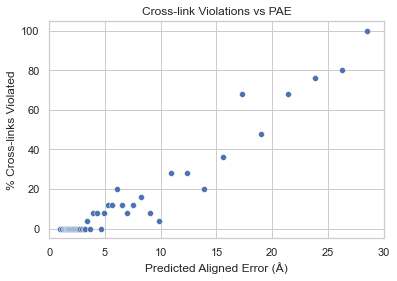

In [130]:
title = 'Cross-link Violations vs PAE'

ax = sns.scatterplot(x=pae_vs_violations['bin_mid'], y=pae_vs_violations['xl_violated'])
ax.set(title=title, xlabel='Predicted Aligned Error (Å)', ylabel='% Cross-links Violated')
sns.set_style("whitegrid")
plt.xlim(0, 30)
plt.ylim(-5, 105)

plt.savefig("figures/{}.svg".format(title))

## Examine PAE pattern to extract cohesive regions for outliers from confidence / XL violation plot

### Replace unrelaxed PTM Alphafold distances with distances from relaxed PTM predictions

In [122]:
example_proteins = [
    "PRKG1",
    "EEF2",
    "MRNC57",
    "I7MJ59",
    "FTT18",
    "BBC118",
    "Q23A15",
    "KARS",
    "I7M6H8",
    "TRAF3IP1",
    "EIF4A",
    "SPEF2",
    "Q22MP6",
    "RPS0"
]

# Get relaxed PTM prediction AF distances for the example proteins
for protein in example_proteins:
    pdb_ca = read_protein_pdb(protein, RELAXED_PTM_PDB_SUFFIX)
    if pdb_ca is None:
        print(protein)
    fill_xls_from_pdb(sanitize_protein(protein), XL_THRESHOLD, pdb_ca, XLs_intra_nonred)

## Identify cohesive regions from PAE heatmap using watershed segmentation

In [123]:
from collections import Counter

regions_cmap = plt.cm.get_cmap("viridis").copy()
regions_cmap.set_bad(color='black')


def make_symmetric(pae):
    pae = np.array(pae)
    return (pae + pae.transpose()) / 2


def make_region_mat_from_labels(region_labels):
    region_labels = np.asarray(region_labels)
    regions_mat = np.array([i if i == j else 0 for i in region_labels for j in region_labels]).reshape(
        region_labels.shape[0], region_labels.shape[0])
    return np.ma.masked_where(regions_mat == 0, regions_mat)


def plot_watershed_process(name, pae, image, denoised, gradient, markers, labels):
    fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(21, 4), sharex=True, sharey=True)
    fig.patch.set_facecolor('white')
    fig.suptitle(name + ' Watershed Segmentation')

    ax = axes.ravel()

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title("Symmetric")

    ax[1].imshow(denoised, cmap=plt.cm.gray)
    ax[1].set_title("Denoised")

    ax[2].imshow(gradient, cmap=plt.cm.nipy_spectral)
    ax[2].set_title("Local Gradient")

    ax[3].imshow(markers, cmap=regions_cmap)
    ax[3].set_title("Markers")

    ax[4].imshow(labels, cmap=regions_cmap)
    ax[4].set_title("Segmented")

    regions_mat = make_region_mat_from_labels(region_labels)

    ax[5].imshow(regions_mat, cmap=regions_cmap)
    ax[5].set_title("Regions")

    img_pae_original = (pae - np.min(pae)) / (np.max(pae) - np.min(pae))

    ax[6].imshow(regions_mat, cmap=regions_cmap, alpha=1 - img_pae_original)
    ax[6].set_title("Original with Regions Overlayed")
    ax[6].set_xlabel("Scored Residue")
    ax[6].set_ylabel("Aligned Residue")

    for one_ax in ax:
        one_ax.grid(False)

    fig.tight_layout()
    fig.savefig("figures/watershed/{}.svg".format(sanitize_protein(name)))
    plt.show()


def predict_watershed(name, pae, denoise_footprint, marker_footprint, marker_threshold, gradient_footprint,
                      repeat_denoise, remove_thin_regions, region_edge_threshold):
    """Label all residues in the same well-predicted regions based on watershed segmentation of PAE."""

    # Make symmetric - easier to determine segmentation
    pae = make_symmetric(pae)

    img_pae = (pae - np.min(pae)) / (np.max(pae) - np.min(pae))
    image = img_as_ubyte(img_pae)

    # denoise image
    denoised = rank.median(image, square(denoise_footprint))

    if repeat_denoise > 1:
        for i in range(0, repeat_denoise):
            denoised = rank.median(denoised, square(denoise_footprint))

    # find continuous region (low gradient -
    # where less than marker_threshold for this image) --> markers
    # square(marker_footprint) is used here to get a more smooth image
    markers = rank.gradient(denoised, square(marker_footprint)) < marker_threshold
    markers = ndi.label(markers)[0]

    # local gradient (square(gradient_footprint) is used to keep edges thin)
    gradient = rank.gradient(denoised, square(gradient_footprint))

    # process the watershed
    labels = watershed(gradient, markers)

    diagonal = np.diagonal(np.array(labels))
    region_labels = diagonal.copy()

    # Remove labels in segments which are less than 2*region_edge_threshold wide on the diagonal
    if remove_thin_regions:
        for i in range(0, len(region_labels)):
            label = region_labels[i]
            before = 0
            after = 0
            if i >= region_edge_threshold:
                before = labels[i, i - region_edge_threshold]
            if i + region_edge_threshold < region_labels.shape[0]:
                after = labels[i, i + region_edge_threshold]
            if before != label and after != label:
                region_labels[i] = 0

    regions_count = np.bincount(region_labels)
    region_count_threshold = 30
    segment_background_labels = []
    # If there are "background" non-region labels, mark as 0
    if len(regions_count) > 1:
        segment_background_labels.append(labels[0, len(region_labels) - 1])
        segment_background_labels.append(labels[len(region_labels) - 1, 0])
    for i in range(0, len(region_labels)):
        if region_labels[i] in segment_background_labels:
            region_labels[i] = 0
        if regions_count[region_labels[i]] < region_count_threshold:
            region_labels[i] = 0

    # Fill empty gaps in labeled regions, and renumber labels starting from 1
    regions_counter = Counter(region_labels)
    fill_label = 0
    current_label = None
    for i in range(0, len(region_labels)):
        if region_labels[i] != 0:
            # Determine region label and count down to end of region
            if region_labels[i] != current_label:
                current_label = region_labels[i]
                fill_label += 1
            region_labels[i] = fill_label
            regions_counter[current_label] = regions_counter[current_label] - 1
            if regions_counter[current_label] == 0:
                current_label = None
        elif current_label is not None:
            # Fill in 0s with label
            region_labels[i] = fill_label

    plot_watershed_process(name, pae, image, denoised, gradient, markers, labels)

    return region_labels


def predict_watershed_for_protein(protein_with_parameters):
    (protein, denoise_footprint, marker_footprint, marker_threshold, gradient_footprint, repeat_denoise,
     remove_thin_regions, region_edge_threshold) = protein_with_parameters
    pae = read_protein_pae_relaxed(protein)

    return predict_watershed(protein, pae, denoise_footprint, marker_footprint, marker_threshold, gradient_footprint,
                             repeat_denoise, remove_thin_regions, region_edge_threshold).tolist()


def predict_watershed_for_proteins(proteins_with_parameters):
    labels = {}
    for protein_with_parameters in proteins_with_parameters:
        labels[protein_with_parameters[0]] = predict_watershed_for_protein(protein_with_parameters)
    return labels


NameError: name 'region_labels' is not defined

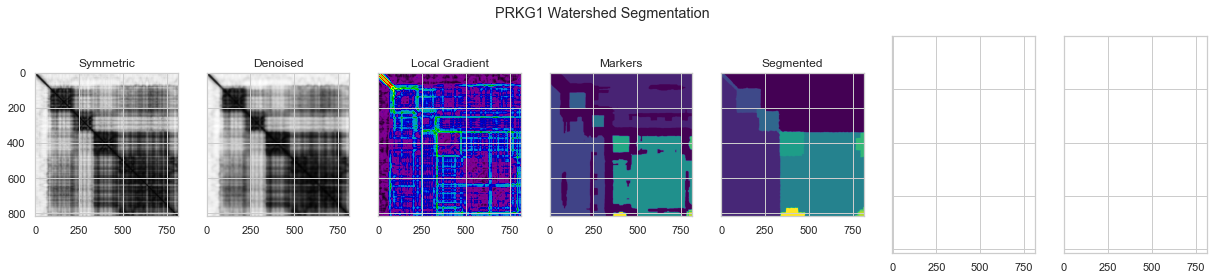

In [124]:
# denoise_footprint, marker_footprint, marker_threshold, gradient_footprint, repeat_denoise, region_edge_threshold
example_proteins_watershed_settings = [
    ("PRKG1", 12, 50, 115, 10, 1, True, 20),  # good
    ("EEF2", 15, 40, 30, 3, 3, False, 5),  # okay
    ("MRNC57", 15, 65, 105, 10, 2, True, 50),  # okay
    ("I7MJ59", 10, 50, 140, 10, 1, True, 40),  # good
    ("FTT18", 10, 10, 40, 4, 1, True, 40),  # good
    ("BBC118", 10, 50, 100, 5, 1, True, 20),  # good
    ("Q23A15", 10, 50, 150, 10, 1, True, 40),  # good
    ("KARS", 10, 45, 150, 10, 1, True, 40),  # good
    ("I7M6H8", 10, 40, 55, 5, 1, False, 20),  #okay
    ("TRAF3IP1", 10, 50, 150, 10, 1, True, 40),  # good
    ("EIF4A", 10, 50, 150, 10, 1, True, 40),  # good
    ("SPEF2", 10, 10, 40, 20, 1, True, 35),  # bad
    ("Q22MP6", 15, 60, 95, 10, 1, True, 40),  # good
    ("RPS0", 10, 50, 150, 10, 1, True, 40)  # good
]

labels = predict_watershed_for_proteins(example_proteins_watershed_settings)
labels

In [ ]:
with open(PATH_WATERSHED_LABELS, 'w') as watershed_labels_out:
    json.dump(labels, watershed_labels_out)

### Corresponding proteins in Uniprot

[I7M6H8](https://www.uniprot.org/uniprot/I7M6H8)
* Domain (IMPDH) 104-600

[Q23A15](https://www.uniprot.org/uniprot/Q23A15)
* Disordered 1 - 20
* Disordered 93 - 157
* Compositional Bias (Polar residues) 96 - 141
* Disordered 242 - 278
* Disordered 324 - 364
* Disordered 395 - 441
* Coiled Coil 503 - 523

[Q22MP6](https://www.uniprot.org/uniprot/Q22MP6)
* Disordered 1-38
* Disordered 401 - 420
* Coiled Coil 156 - 176
* Domain (Protein Kinase) 116 - 455
* Repeat (TPR) 606 - 639

[I7MJ59](https://www.uniprot.org/uniprot/I7MJ59)
* Disordered 1-41
* Coiled Coil 119 - 139
* Coiled Coil 150 - 194
* Coiled Coil 203 - 237
* Coiled Coil 247 - 267
* Coiled Coil 332 - 362
* Disordered 496 - 515
* Disordered 614 - 633

Maybe a supplementary table

## Classify agreements / violations as intra-region or inter-region

In [ ]:
def is_intraregion(region_labels, res1, res2):
    """Determine if the two residue positions are within the same non-background region"""
    return region_labels[res1 - 1] != 0 and region_labels[res1 - 1] == region_labels[res2 - 1]


# Re-calculate violated XLs based on the PTM distances
XLs_intra_nonred['xl_violated'] = XLs_intra_nonred['af_distance'] > XL_THRESHOLD
XLs_intra_nonred['is_intraregion'] = None

for protein in example_proteins:
    region_labels = labels[protein]
    XLs_intra_nonred['is_intraregion'] = XLs_intra_nonred.apply(
        lambda x: x['is_intraregion'] if x['Protein1'] != protein else is_intraregion(region_labels, x['newRes1'],
                                                                                      x['newRes2']), axis=1)

pd.crosstab(XLs_intra_nonred['xl_violated'], XLs_intra_nonred['is_intraregion'], normalize='index')

## Differences in 5 models of EEF2

In [ ]:
eef2_xls = XLs_intra_nonred[XLs_intra_nonred['Protein1'] == 'EEF2']
eef2_xls

In [ ]:
pd.crosstab(eef2_xls['xl_violated'], eef2_xls['is_intraregion'], normalize='index')

## Combine Figures

### Plot pairwise Predicted Aligned Error values as heatmap with XL violations and agreements overlayed

In [ ]:
from scipy import ndimage as ndi
from skimage.morphology import square
from skimage.segmentation import watershed
from skimage.filters import rank
from skimage.util import img_as_ubyte


def plot_plddt(protein):
    sanitized_protein = sanitize_protein(protein)
    results = pd.read_pickle('results/' + sanitized_protein + RESULTS_PKL_SUFFIX)

    plddt = results['plddt']

    plt.figure(figsize=[16, 6])
    plt.subplot(1, 2, 1)
    plt.plot(plddt)
    plt.title('Predicted LDDT')
    plt.xlabel('Residue')
    plt.ylabel('pLDDT')


def plot_pae_xls(protein, ax, fig):
    pae = read_protein_pae_relaxed(protein)

    protein_xls = XLs_intra_nonred.loc[XLs_intra_nonred['Protein1'] == protein]

    protein_xls_agreed = protein_xls[protein_xls['af_distance'] <= XL_THRESHOLD]
    protein_xls_missed = protein_xls[protein_xls['af_distance'] > XL_THRESHOLD]

    im = ax.imshow(pae, cmap='gray', alpha=0.5, vmin=0, vmax=31)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, ticks=[0, 30])
    cbar.ax.set_ylabel('PAE (Å)', rotation=270, position=(10, 0.5))
    ax.scatter(protein_xls_agreed['newRes1'] - 1, protein_xls_agreed['newRes2'] - 1, marker='o', facecolor='none',
               edgecolor='darkblue', linewidths=2)
    ax.scatter(protein_xls_missed['newRes1'] - 1, protein_xls_missed['newRes2'] - 1, marker='x', c='darkred',
               linewidths=2)

    ax.set_title('PAE and Cross-links within ' + str(XL_THRESHOLD) + 'Å')
    ax.set_xlabel('Scored residue')
    ax.set_ylabel('Aligned residue')
    ax.grid(False)

In [ ]:
def plot_watershed_regions(pae, region_labels, ax):
    img_pae_original = (pae - np.min(pae)) / (np.max(pae) - np.min(pae))

    regions_mat = make_region_mat_from_labels(region_labels)

    ax.imshow(regions_mat, cmap=regions_cmap, alpha=1 - img_pae_original)
    ax.set_title("Watershed Predicted Regions")
    ax.set_xlabel("Scored Residue")
    ax.set_ylabel("Aligned Residue")
    ax.grid(False)

In [ ]:
import matplotlib.image as mpimg

for protein in example_proteins:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), gridspec_kw={'width_ratios': [2, 2, 3]})
    fig.patch.set_facecolor('white')
    fig.suptitle(protein)
    ax = axes.ravel()

    plot_pae_xls(protein, ax[0], fig)
    plot_watershed_regions(paes_relaxed[protein], labels[protein], ax[1])

    ax[2].imshow(mpimg.imread('chx/PTM/Images/{}.png'.format(sanitize_protein(protein))))
    ax[2].set_title("Structure with Watershed Regions and Cross-links")
    ax[2].grid(False)
    ax[2].axes.xaxis.set_visible(False)
    ax[2].axes.yaxis.set_visible(False)

    fig.tight_layout()
    plt.savefig("figures/{}.svg".format(sanitize_protein(protein)))

# WIP

In [ ]:
# IMP - can try out for fun

In [ ]:
# TODO:

# Align example relaxed PTM structures to unrelaxed, make sure they aren't super different